In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score as aprs, auc, precision_recall_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.pipeline import Pipeline

In [3]:
def performance(y_test, y_pred, y_pred_prob):

    confusion_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True_0', 'True_1'], 
                                 columns=['Predicted_0', 'Predicted_1'])
    # AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:,1])
    auprc = auc(recall, precision)
    print("AUPRC score: {:.4f}".format(auprc))
    # AUROC
    auroc = roc_auc_score(y_test, y_pred_prob[:, 1])
    print("AUROC score: {:.4f}".format(auroc))
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy Score: {:.4f}".format(acc))
    return confusion_mat

In [16]:
def model_fitting(X, y, estimator, params = {}, score = 'roc_auc', results = True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    pipe = Pipeline([('scale', StandardScaler()), ('model', estimator)])
    
    clf = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, scoring=score)
    clf.fit(X_train, y_train)
    best_parameters = clf.best_params_
    
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    
    if results:
        return performance(y_test, y_pred, y_pred_prob)
    else:
        return best_parameters, y_test, y_pred, y_pred_prob

### Feature Importance

In [19]:
def get_best_model(best_parameters, X_train, y_train):
    xgb_model_best = xgb.XGBClassifier(learning_rate= best_parameters['model__learning_rate'], max_depth=best_parameters['model__max_depth'],
                                  n_estimators = best_parameters['model__n_estimators'])
    
    xgb_model_best.fit(X_train, y_train)
    return xgb_model_best

def get_feat_names(feat_dict, colnames, k):
    # Sorting the keys based on values/scores of features 
    feat_sorted = sorted(feat_dict, key = feat_dict.get, reverse=True)
    top_k_features = []
    for i in range(k):
        idx = int(feat_sorted[i][1:])
        top_k_features.append(colnames[idx])
        
    return top_k_features
        

def feature_importance(best_parameters, X, y, colnames, k = 5, metric = 'weight'):
    
    model = get_best_model(best_parameters, X, y)
    
    features = model.get_booster().get_score(importance_type= metric)
    top_k_features = get_feat_names(features, colnames, k)
    
#     df = pd.DataFrame(top_k_features, index=range(1, k+1), columns=['Features'])
#     return df
    return top_k_features

"Gain" implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. "Weight" is the percentage representing the relative number of times a particular feature occurs in the trees of the model

## Logistic Regression without metadata

Here we use on TCGA data and exclude SRR

In [8]:
input_df = pd.read_csv('data/sample_input.tsv', delimiter='\t')

In [9]:
# Indexing rows on sample ID
input_df.set_index('sample_id', inplace=True)
input_df.head()

,Y,ENSG00000148926,ENSG00000109107,ENSG00000176171,ENSG00000104765,ENSG00000074410,ENSG00000107159,ENSG00000130635,ENSG00000047457,ENSG00000168209,...,ENSG00000204531,ENSG00000119938,ENSG00000139832,ENSG00000141526,ENSG00000117394,ENSG00000103257,ENSG00000113739,ENSG00000112715,ENSG00000186918,ENSG00000117289
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-CQ-6224-01A,1,24981.975124,4696.857413,21113.748716,21269.477512,52778.604056,6411.796755,933526.846327,369.134926,33772.000541,...,278.773772,2262.873997,2226.345020,27221.778188,313851.202794,129504.836413,6488.699865,18241.417575,12352.561965,159604.713475
TCGA-TQ-A7RP-01A,1,5610.244305,530004.403530,11676.755743,45755.613927,74627.297875,42.966860,1119.184404,5055.767205,53663.562227,...,149.360990,17391.348137,2195.401947,2895.147955,58475.850559,86477.967100,826.600547,21978.571963,6721.244545,94302.027720
TCGA-13-1510-01A,1,48067.429675,2622.282664,29362.588588,23352.464020,45830.833818,7486.975559,17059.373251,64617.076140,51166.491005,...,2118.370253,591.128021,6622.571961,15388.709795,142378.513720,16795.788297,8202.143558,226089.994003,17431.493186,276363.009540
TCGA-HC-8265-01A,1,1907.628187,6635.703780,22342.206919,16449.876874,2159.063421,95.654709,12331.258424,5922.392953,15884.147598,...,956.547085,1954.089045,5312.935810,2435.095580,13678.623318,5326.600769,2323.042921,41904.961307,21251.743242,221287.602691
TCGA-HC-7079-01A,1,4545.560305,4391.803858,6366.816244,21101.448122,3826.586497,60.636345,22957.353401,49390.468731,6914.708934,...,409.295330,3209.395127,9119.273198,11024.986904,11934.532081,12878.726599,1708.645584,21816.090761,17142.761015,140639.505888


In [8]:

# filtering out TCGA samples since SRR contains only normal tumor data
tcga_df = input_df.filter(like = 'TCGA', axis = 0)

y = tcga_df["Y"].values
X = tcga_df.drop(columns = ["Y"]).values

In [20]:
model_fitting(X, y, LogisticRegression(class_weight = 'balanced') )

AUPRC score: 0.9930
AUROC score: 0.9318
Accuracy Score: 0.9395


,Predicted_0,Predicted_1
True_0,77,165
True_1,24,2857


## Decision Tree

In [26]:
dt_model = DTC(class_weight="balanced")
params = {'model__max_depth':  [5, 6,7, 8],
          'model__min_samples_split' : [2, 3],
            
}
model_fitting(X, y, dt_model, params=params)

AUPRC score: 0.9895
AUROC score: 0.8790
Accuracy Score: 0.9232


,Predicted_0,Predicted_1
True_0,197,45
True_1,195,2686


## XGBoost

In [27]:
xgb_model = xgb.XGBClassifier()

params = {'model__max_depth':  [6,7, 8],
          'model__learning_rate' : [0.01, 0.1],
          'model__n_estimators' : [ 300, 500],
            
}
model_fitting(X, y, xgb_model, params=params)

AUPRC score: 0.9994
AUROC score: 0.9937
Accuracy Score: 0.9817


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Predicted_0,Predicted_1
True_0,195,47
True_1,10,2871


### Boxplot of gene expression level for "important" genes

We choose 'gain' as the importance type since it best conforms with the ranking we already have

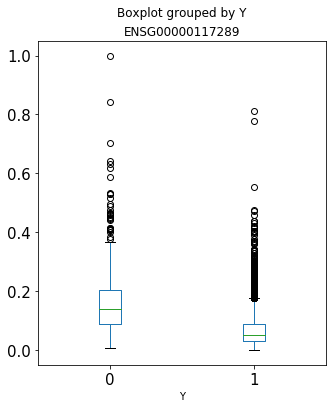

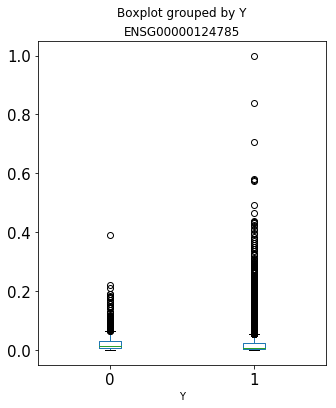

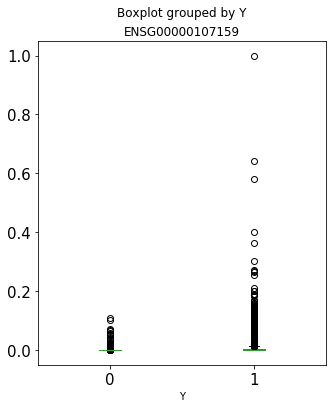

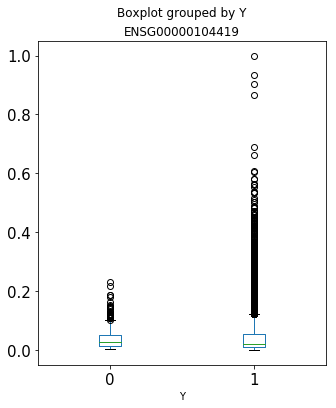

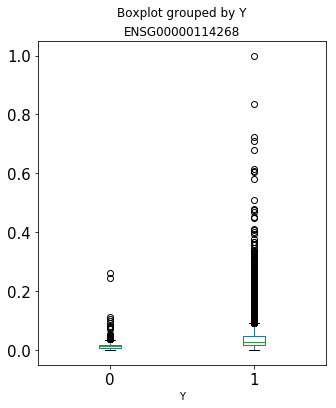

In [75]:
top_genes = feature_importance(best_parameters, X_train, y_train, input_df.columns.values[1:], metric='gain')

# scaler = StandardScaler()
scaler = MinMaxScaler()
gene_exp = tcga_df[top_genes]
gene_exp_scaled = scaler.fit_transform(gene_exp.values)
tcga_df[top_genes] = gene_exp_scaled
for g_id in top_genes:
    tcga_df.boxplot(column = [g_id], by = 'Y', grid=False, fontsize=15, figsize=(5, 6))

In [20]:
## Code taken from https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

model = xgb_model_best

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.009, n=34, Accuracy: 97.18%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.009, n=33, Accuracy: 97.28%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.010, n=32, Accuracy: 97.37%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.010, n=31, Accuracy: 97.28%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.011, n=30, Accuracy: 97.31%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.011, n=29, Accuracy: 97.28%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.011, n=28, Accuracy: 97.37%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.012, n=27, Accuracy: 97.41%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.013, n=26, Accuracy: 97.37%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.014, n=25, Accuracy: 97.34%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.014, n=24, Accuracy: 97.28%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.015, n=23, Accuracy: 97.18%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.016, n=22, Accuracy: 97.34%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.019, n=21, Accuracy: 97.15%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.020, n=20, Accuracy: 97.21%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.020, n=19, Accuracy: 97.05%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.022, n=18, Accuracy: 97.09%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.023, n=17, Accuracy: 97.12%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.023, n=16, Accuracy: 97.15%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.029, n=15, Accuracy: 97.09%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.031, n=14, Accuracy: 96.93%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.032, n=13, Accuracy: 96.86%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.032, n=12, Accuracy: 96.70%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.034, n=11, Accuracy: 96.64%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.034, n=10, Accuracy: 96.64%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.035, n=9, Accuracy: 96.51%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.042, n=8, Accuracy: 96.38%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.042, n=7, Accuracy: 96.25%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.044, n=6, Accuracy: 95.68%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.049, n=5, Accuracy: 95.04%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.054, n=4, Accuracy: 94.72%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.057, n=3, Accuracy: 93.98%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.065, n=2, Accuracy: 92.89%
Thresh=0.137, n=1, Accuracy: 92.35%


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Training on TCGA and Prediction on SRR

In [11]:
tcga_df = input_df.filter(like = 'TCGA', axis = 0)

y_tcga = tcga_df["Y"].values
X_tcga = tcga_df.drop(columns = ["Y"]).values
# X_tcga_scaled = scale.fit_transform(X_tcga)

In [79]:
xgb_model = xgb.XGBClassifier()

params = {'max_depth':  [6,7, 8],
          'learning_rate' : [0.01, 0.1],
          'n_estimators' : [ 300, 500],
          #'min_child_weight': [5, 11, 15]
            
}
clf = GridSearchCV(xgb_model, params, n_jobs=50, 
                   cv= 5, 
                   scoring='roc_auc',
                   verbose=2, refit=True)
clf.fit(X_tcga_scaled, y_tcga)
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=50)]: Done  23 out of  60 | elapsed:  2.8min remaining:  4.5min
[Parallel(n_jobs=50)]: Done  54 out of  60 | elapsed:  3.4min remaining:   22.3s
[Parallel(n_jobs=50)]: Done  60 out of  60 | elapsed:  3.4min finished
C:\APPS\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [80]:
SRR_df = input_df.filter(like = 'SRR', axis = 0)
y_srr = SRR_df['Y'].values
X_srr = SRR_df.drop(columns = ['Y']).values

In [39]:
y_srr_pred = clf.predict(scale.transform(X_srr))
confusion_matrix(y_srr, y_srr_pred)

C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 355, 1419],
       [   0,    0]], dtype=int64)

## XGBoost with metadata

Here we use on TCGA data and exclude SRR

In [12]:
metadata = pd.read_csv('data/tcga_metadata.tsv', delimiter= '\t')

metadata.head()

,study,sample_id,gender
0,HNSC,TCGA-CQ-6224-01A,MALE
1,LGG,TCGA-TQ-A7RP-01A,MALE
2,OV,TCGA-13-1510-01A,FEMALE
3,PRAD,TCGA-HC-8265-01A,MALE
4,PRAD,TCGA-HC-7079-01A,MALE


In [13]:
#Merging Metadata with the input by matching the sample ID

merged_df = pd.merge(metadata, tcga_df, how = 'right', left_on=['sample_id'], right_on=['sample_id'])
merged_df.head()

,study,sample_id,gender,Y,ENSG00000148926,ENSG00000109107,ENSG00000176171,ENSG00000104765,ENSG00000074410,ENSG00000107159,...,ENSG00000204531,ENSG00000119938,ENSG00000139832,ENSG00000141526,ENSG00000117394,ENSG00000103257,ENSG00000113739,ENSG00000112715,ENSG00000186918,ENSG00000117289
0,HNSC,TCGA-CQ-6224-01A,MALE,1,24981.975124,4696.857413,21113.748716,21269.477512,52778.604056,6411.796755,...,278.773772,2262.873997,2226.345020,27221.778188,313851.202794,129504.836413,6488.699865,18241.417575,12352.561965,159604.713475
1,LGG,TCGA-TQ-A7RP-01A,MALE,1,5610.244305,530004.403530,11676.755743,45755.613927,74627.297875,42.966860,...,149.360990,17391.348137,2195.401947,2895.147955,58475.850559,86477.967100,826.600547,21978.571963,6721.244545,94302.027720
2,OV,TCGA-13-1510-01A,FEMALE,1,48067.429675,2622.282664,29362.588588,23352.464020,45830.833818,7486.975559,...,2118.370253,591.128021,6622.571961,15388.709795,142378.513720,16795.788297,8202.143558,226089.994003,17431.493186,276363.009540
3,PRAD,TCGA-HC-8265-01A,MALE,1,1907.628187,6635.703780,22342.206919,16449.876874,2159.063421,95.654709,...,956.547085,1954.089045,5312.935810,2435.095580,13678.623318,5326.600769,2323.042921,41904.961307,21251.743242,221287.602691
4,PRAD,TCGA-HC-7079-01A,MALE,1,4545.560305,4391.803858,6366.816244,21101.448122,3826.586497,60.636345,...,409.295330,3209.395127,9119.273198,11024.986904,11934.532081,12878.726599,1708.645584,21816.090761,17142.761015,140639.505888


In [14]:
categoric_df = pd.get_dummies(merged_df, columns=["study", "gender"])

y = categoric_df["Y"].values
X = categoric_df.drop(columns = ["sample_id", "Y"]).values



In [15]:
xgb_model = xgb.XGBClassifier()

params = {'model__max_depth':  [7, 8, 9],
          'model__learning_rate' : [0.01, 0.1, 0.2],
          'model__n_estimators' : [ 300, 500, 700],            
}

best_parameters, _ , y_pred, y_pred_prob = model_fitting(X, y, xgb_model, params=params, results=False)

C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
performance(y_test, y_pred, y_pred_prob)

AUPRC score: 0.9994
AUROC score: 0.9932
Accuracy Score: 0.9801


,Predicted_0,Predicted_1
True_0,186,45
True_1,18,2911


In [21]:
feature_importance(best_parameters, X_train, y_train, categoric_df.columns.values[2:], metric='gain')

['ENSG00000117289',
 'study_LUSC',
 'study_KIRP',
 'study_PRAD',
 'ENSG00000107159']

## XGBoost with both TCGA and SRR

In [22]:
input_df = pd.read_csv('data/sample_input.tsv', delimiter='\t')

In [89]:
input_df.head()

,sample_id,Y,ENSG00000148926,ENSG00000109107,ENSG00000176171,ENSG00000104765,ENSG00000074410,ENSG00000107159,ENSG00000130635,ENSG00000047457,...,ENSG00000204531,ENSG00000119938,ENSG00000139832,ENSG00000141526,ENSG00000117394,ENSG00000103257,ENSG00000113739,ENSG00000112715,ENSG00000186918,ENSG00000117289
0,TCGA-CQ-6224-01A,1,24981.975124,4696.857413,21113.748716,21269.477512,52778.604056,6411.796755,933526.846327,369.134926,...,278.773772,2262.873997,2226.345020,27221.778188,313851.202794,129504.836413,6488.699865,18241.417575,12352.561965,159604.713475
1,TCGA-TQ-A7RP-01A,1,5610.244305,530004.403530,11676.755743,45755.613927,74627.297875,42.966860,1119.184404,5055.767205,...,149.360990,17391.348137,2195.401947,2895.147955,58475.850559,86477.967100,826.600547,21978.571963,6721.244545,94302.027720
2,TCGA-13-1510-01A,1,48067.429675,2622.282664,29362.588588,23352.464020,45830.833818,7486.975559,17059.373251,64617.076140,...,2118.370253,591.128021,6622.571961,15388.709795,142378.513720,16795.788297,8202.143558,226089.994003,17431.493186,276363.009540
3,TCGA-HC-8265-01A,1,1907.628187,6635.703780,22342.206919,16449.876874,2159.063421,95.654709,12331.258424,5922.392953,...,956.547085,1954.089045,5312.935810,2435.095580,13678.623318,5326.600769,2323.042921,41904.961307,21251.743242,221287.602691
4,TCGA-HC-7079-01A,1,4545.560305,4391.803858,6366.816244,21101.448122,3826.586497,60.636345,22957.353401,49390.468731,...,409.295330,3209.395127,9119.273198,11024.986904,11934.532081,12878.726599,1708.645584,21816.090761,17142.761015,140639.505888


In [23]:
# Indexing rows on sample ID
input_df.set_index('sample_id', inplace=True)

y = input_df["Y"].values
X = input_df.drop(columns = ["Y"]).values

In [24]:
xgb_model = xgb.XGBClassifier()

params = {'model__max_depth':  [7, 8, 9],
          'model__learning_rate' : [0.01, 0.1, 0.2],
          'model__n_estimators' : [ 300, 500, 700],
         }          

best_parameters, _ , y_pred, y_pred_prob = model_fitting(X, y, xgb_model, params=params, results=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
performance(y_test, y_pred, y_pred_prob)

AUPRC score: 0.9988
AUROC score: 0.9958
Accuracy Score: 0.9795


C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Predicted_0,Predicted_1
True_0,751,44
True_1,32,2881


In [25]:
feature_importance(best_parameters, X_train, y_train, input_df.columns.values[1:], metric='gain')

['ENSG00000117289',
 'ENSG00000124785',
 'ENSG00000159399',
 'ENSG00000117394',
 'ENSG00000139832']

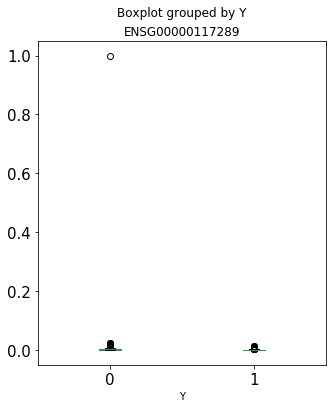

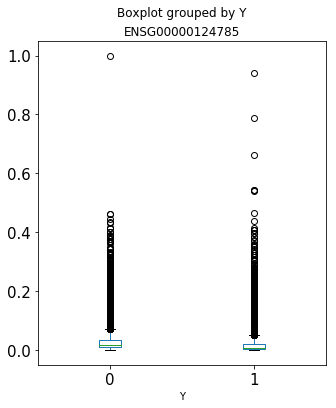

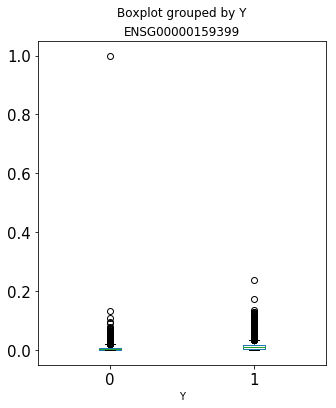

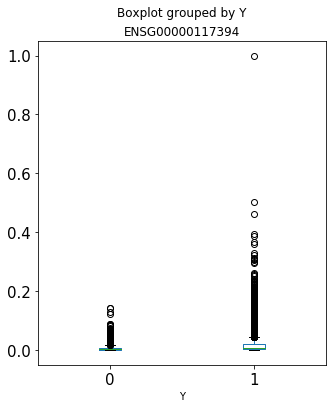

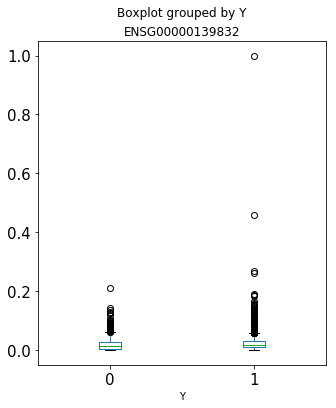

In [26]:
top_genes = feature_importance(best_parameters, X_train, y_train, input_df.columns.values[1:], metric='gain')

# scaler = StandardScaler()
scaler = MinMaxScaler()
gene_exp = input_df[top_genes]
gene_exp_scaled = scaler.fit_transform(gene_exp.values)
input_df[top_genes] = gene_exp_scaled
for g_id in top_genes:
    input_df.boxplot(column = [g_id], by = 'Y', grid=False, fontsize=15, figsize=(5, 6))

## Summary

We start with the simplest possible case, i.e. classifying only TCGA data without metadata. LR works well but not so great, however, XGB improves scores greatly. Although, including metadata does not help

Then we add SRR samples to TCGA and implement XGB again. Results improve possibly due to reduction in imbalance.